# Análisis de Predicción de Tendencia

Analizamos y realizamos el análisis de los textos de las opiniones de las revisiones por parte de los usuarios, para conocer la polaridad de la smismas. Luego, en base a dicha información y al comportamiento a traves del tiempo, trazamos la tendencia para conocer cuales son los restaurantes que vienen ascendiendo y del que se espera una buena experiencia.
Ulitizamos las librerías de Python Textblob para extraer la polaridad de las opiniones y Prophet para el análisis de series de tiempo

In [1]:
import pandas as pd
from prophet import Prophet
#import plotly.graph_objs as go
from textblob import TextBlob
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning, module="fbprophet")

Importing plotly failed. Interactive plots will not work.


In [2]:
ruta = "FINAL_FLORIDA.parquet"
dfMain = pd.read_parquet(ruta)
dfMain.head(2)

,business_name,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,user_name,time,rating,text
1,Honduras Nica Cafe,"Honduras Nica Cafe, 280 NW 79th St, Miami, FL ...",None,25.847143,-80.20237,['Honduran restaurant'],3.5,84,None,"[[Thursday, 7AM–9PM], [Friday, 7AM–10PM], [Sat...",{'Accessibility': ['Wheelchair accessible entr...,Closes soon ⋅ 9PM ⋅ Opens 7AM Fri,Cindys 4luvz,17/04/2021,4.0,The nacatamal is a good size and taste ok. The...
2,Honduras Nica Cafe,"Honduras Nica Cafe, 280 NW 79th St, Miami, FL ...",None,25.847143,-80.20237,['Honduran restaurant'],3.5,84,None,"[[Thursday, 7AM–9PM], [Friday, 7AM–10PM], [Sat...",{'Accessibility': ['Wheelchair accessible entr...,Closes soon ⋅ 9PM ⋅ Opens 7AM Fri,Ash Jay,07/06/2021,5.0,Love this place thats my favorite place


In [3]:
dfMain.describe()

,latitude,longitude,avg_rating,num_of_reviews,rating
count,563227.000000,563227.000000,563227.000000,563227.000000,563227.000000
mean,28.006870,-81.787380,4.194128,1599.815353,4.178583
std,1.412725,1.493940,0.393995,1367.115332,1.246101
min,25.442958,-87.333840,1.500000,8.000000,1.000000
25%,26.929355,-82.479708,4.000000,728.000000,4.000000
50%,28.019105,-81.558788,4.300000,1296.000000,5.000000
75%,28.684585,-80.699695,4.500000,2088.000000,5.000000
max,30.944592,-80.038204,5.000000,8116.000000,5.000000


In [4]:
# Eliminamos filas con la columna "text" vacía
dfMain = dfMain.dropna(subset=['text'])
dfMain.describe()

,latitude,longitude,avg_rating,num_of_reviews,rating
count,563227.000000,563227.000000,563227.000000,563227.000000,563227.000000
mean,28.006870,-81.787380,4.194128,1599.815353,4.178583
std,1.412725,1.493940,0.393995,1367.115332,1.246101
min,25.442958,-87.333840,1.500000,8.000000,1.000000
25%,26.929355,-82.479708,4.000000,728.000000,4.000000
50%,28.019105,-81.558788,4.300000,1296.000000,5.000000
75%,28.684585,-80.699695,4.500000,2088.000000,5.000000
max,30.944592,-80.038204,5.000000,8116.000000,5.000000


In [5]:
len(dfMain)

563227

In [6]:
dfMain = dfMain.dropna(subset=['description', 'price'])
dfMain = dfMain[dfMain['state'] != 'Temporarily closed']

In [7]:
len(dfMain)

468930

In [8]:
#corregimos valores de moneda
def replace_currency_symbol(value):
    if value is not None and "₩" in value:
        return value.replace("₩", "$")
    else:
        return value

dfMain["price"] = dfMain["price"].apply(replace_currency_symbol)

In [9]:
#msno.matrix(df)
#msno.bar(df)
#plt.show()

## Obtenemos un df solamente con los valores de ubicacion de los restaurantes

In [10]:
df_only_ubication = dfMain[["business_name", "latitude", "longitude"]]
df_only_ubication = df_only_ubication.drop_duplicates()

In [11]:
df_only_ubication

,business_name,latitude,longitude
161,New China Restaurant,28.554136,-81.488496
560,Subway,26.175061,-81.717576
1024,Dunkin,28.474818,-81.474421
1735,Subway,30.468948,-83.410400
2151,Dunkin',27.447711,-80.323777
...,...,...,...
1004990,Subway,26.650773,-80.143629
1005260,MOCA CAFÉ,30.329266,-81.658531
1005304,Domino's Pizza,27.227161,-82.490956
1005508,Tropical Smoothie Cafe,28.761296,-81.284346


In [12]:
#df_only_ubication.to_csv("df_only_ubication.csv")

Conocemos los datos que nos arroja solamente 1 restaurant elegido al azar

In [13]:
dfNewChina = dfMain[dfMain["business_name"] == "New China Restaurant"]

In [14]:
len(dfNewChina)

44

### Polaridad de Review
Aplicamos la funcion de textblob para conocer la polaridad del texto. -1 es negativo y +1 es positivo. 

In [15]:
# Función para obtener la polaridad del texto
def obtener_sentimiento(texto):
    analysis = TextBlob(texto)
    return analysis.sentiment.polarity

dfNewChina['sentimiento'] = dfNewChina['text'].apply(obtener_sentimiento)

/var/folders/v1/fh4jbhjn7zz3zz1zl34vhly00000gn/T/ipykernel_20511/288223731.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNewChina['sentimiento'] = dfNewChina['text'].apply(obtener_sentimiento)


In [16]:
dfNewChina.head(1)

,business_name,address,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,user_name,time,rating,text,sentimiento
161,New China Restaurant,"New China Restaurant, 7649 W Colonial Dr #160,...",Basic takeout & delivery option featuring a tr...,28.554136,-81.488496,['Chinese restaurant' 'Restaurant'],3.8,148,$,"[[Thursday, 11AM–10PM], [Friday, 11AM–11PM], [...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 10PM,Guerlins Oberson,02/05/2021,5.0,This restaurant is pretty good. I would totall...,0.4


### Analisis Serie de Tiempo
Utilizando la librería Prophet, trazamos la tendencia y predecimos el comportamiento 90 días posteriores

/var/folders/v1/fh4jbhjn7zz3zz1zl34vhly00000gn/T/ipykernel_20511/191692963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'time': 'ds', 'sentimiento': 'y'}, inplace=True)
/var/folders/v1/fh4jbhjn7zz3zz1zl34vhly00000gn/T/ipykernel_20511/191692963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')
20:40:57 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing


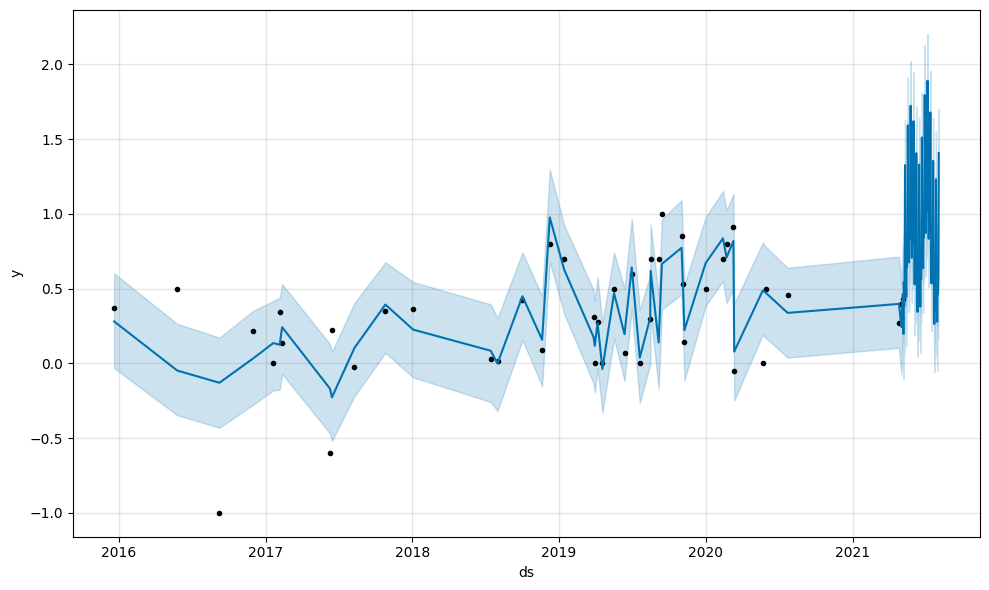

In [18]:
df= dfNewChina

df.rename(columns={'time': 'ds', 'sentimiento': 'y'}, inplace=True)

df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=90) 

forecast = model.predict(future)
fig = model.plot(forecast)

In [19]:
df['year'] = df['ds'].dt.year

/var/folders/v1/fh4jbhjn7zz3zz1zl34vhly00000gn/T/ipykernel_20511/2071588625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['ds'].dt.year


In [21]:
# Contar la cantidad de reseñas por año
reviews_por_anio = df.groupby('year')['y'].count()
reviews_por_anio 

year
2015     1
2016     3
2017     7
2018     6
2019    16
2020     8
2021     3
Name: y, dtype: int64

Conociendo los resultados anteriores, trazamos un filtro, extrayendo los restaurantes que poseen más de 150 reviews en alguno de los años donde tenemos información

In [24]:
dfMain['time'] = pd.to_datetime(dfMain['time'], format='%d/%m/%Y')

# Crea una nueva columna llamada "year" que contendrá el año
dfMain['year'] = dfMain['time'].dt.year

grouped = dfMain.groupby(['business_name', 'year']).size().reset_index(name="count")

# Filtra los grupos en los que la cantidad de reseñas es mayor o igual a x en alguno de los años
filtered = grouped[grouped['count'] >= 150]

print("el tamaño de filtered es de", len(filtered))

el tamaño de filtered es de 705


In [25]:
len(filtered["business_name"].unique())

251

In [26]:
restaurantesUnicos = filtered["business_name"].unique()

In [27]:
filtrado = dfMain[dfMain["business_name"].isin(restaurantesUnicos)]

In [28]:
# Conocemos la polaridad de todos los textos
def obtener_sentimiento(texto):
    analysis = TextBlob(texto)
    return analysis.sentiment.polarity

filtrado['sentimiento'] = filtrado['text'].apply(obtener_sentimiento)

/var/folders/v1/fh4jbhjn7zz3zz1zl34vhly00000gn/T/ipykernel_20511/2633047308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtrado['sentimiento'] = filtrado['text'].apply(obtener_sentimiento)


In [29]:
dfUnico = filtrado["business_name"].unique()
dfUnico.head(3)

array(['Subway', "Dunkin'", "Domino's Pizza", 'Pizza Hut', 'Chick-fil-A',
       'Checkers', 'Burger King', "Jimmy John's",
       'Dairy Queen Grill & Chill', 'First Watch',
       'Tropical Smoothie Cafe', "Papa John's Pizza",
       'Little Caesars Pizza', "McDonald's", 'Starbucks', 'Shake Shack',
       'Taco Bell', 'Chipotle Mexican Grill', 'Bonefish Grill', "Wendy's",
       "Culver's", 'China Buffet', "Arby's", 'Another Broken Egg Cafe',
       "Moe's Southwest Grill", 'Bubba Gump Shrimp Co.', 'Panda Express',
       'Hot Dog Heaven', 'BrewBurgers', 'Pollo Tropical', 'Wingstop',
       'TGI Fridays', 'Waffle House', "Carrabba's Italian Grill",
       'Lightsey Fish Co & Seafood', 'LongHorn Steakhouse', 'Whataburger',
       "Donna's Caribbean Restaurant", 'Einstein Bros. Bagels',
       'Tijuana Flats', 'Chef Lins Asian Buffet', '4 Rivers Smokehouse',
       "Denny's", "Bono's Pit Bar-B-Q", 'Midtown Caboose',
       'Kobe Japanese Steakhouse', 'Popeyes Louisiana Kitchen',
      

Probamos los resultados con un restaurante al azar

/var/folders/v1/fh4jbhjn7zz3zz1zl34vhly00000gn/T/ipykernel_20511/1973711162.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'time': 'ds', 'sentimiento': 'y'}, inplace=True)
/var/folders/v1/fh4jbhjn7zz3zz1zl34vhly00000gn/T/ipykernel_20511/1973711162.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')
20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing


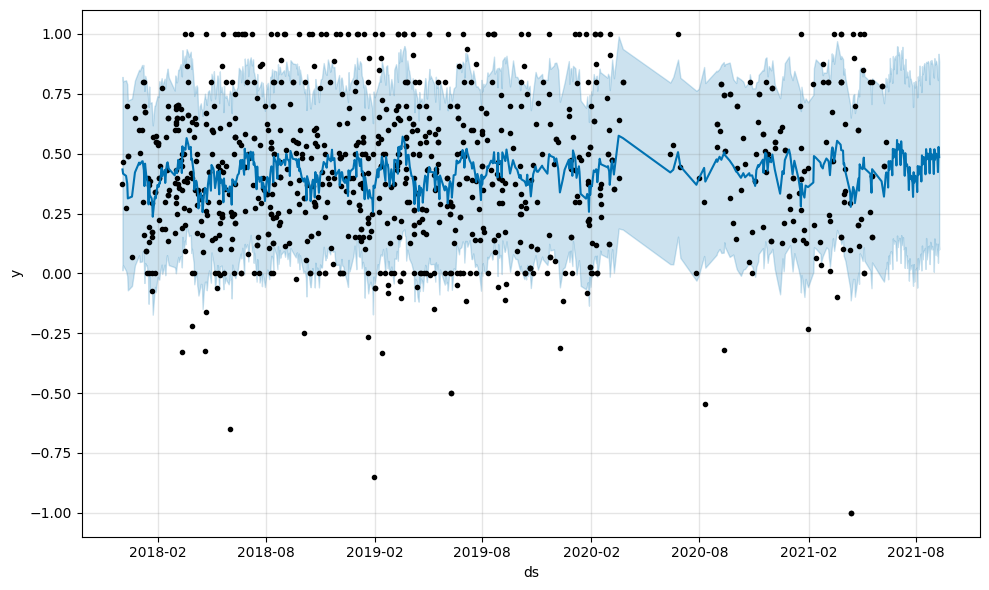

In [30]:
name = "1-800-Lucky"

df= filtrado[filtrado["business_name"] == name]

# Renombra las columnas a "ds" y "y"
df.rename(columns={'time': 'ds', 'sentimiento': 'y'}, inplace=True)

df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Crea un modelo Prophet
model = Prophet()

# Ajusta el modelo a tus datos
model.fit(df)

# Genera un DataFrame con fechas futuras para hacer predicciones
future = model.make_future_dataframe(periods=90)  # Aquí puedes ajustar el período que desees

# Realiza las predicciones
forecast = model.predict(future)

# Grafica las predicciones
fig = model.plot(forecast)

En el gráfico anterior podemos ver que tenemos muchos mas resultados que en el primer análisis. Podemos basar asi nuestra decisión en los resultados que nos dará este análisis

### Componentes de Serie de Tiempo
Uno de los atributos de esta librería, es brindarnos información valiosa de "componentes" de seire de tiempo. Entre ellos tendencia, rating semanal y rating mensual. 

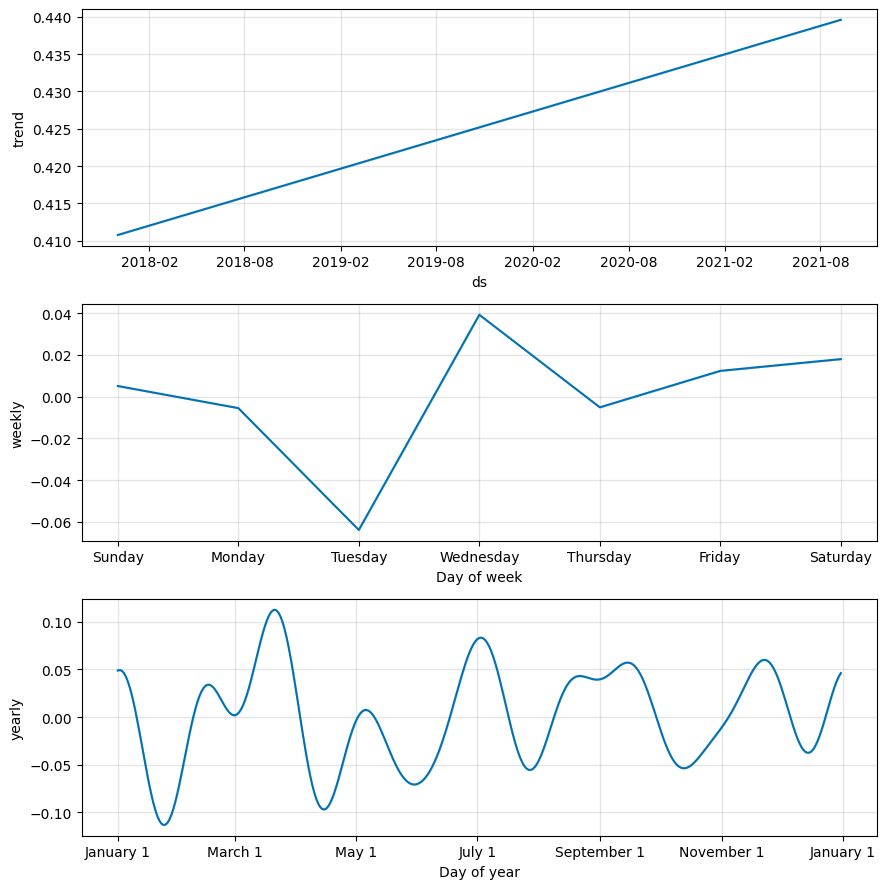

In [32]:
model.plot_components(forecast)
plt.show()

Analizamos otro caso

20:41:54 - cmdstanpy - INFO - Chain [1] start processing
20:41:54 - cmdstanpy - INFO - Chain [1] done processing


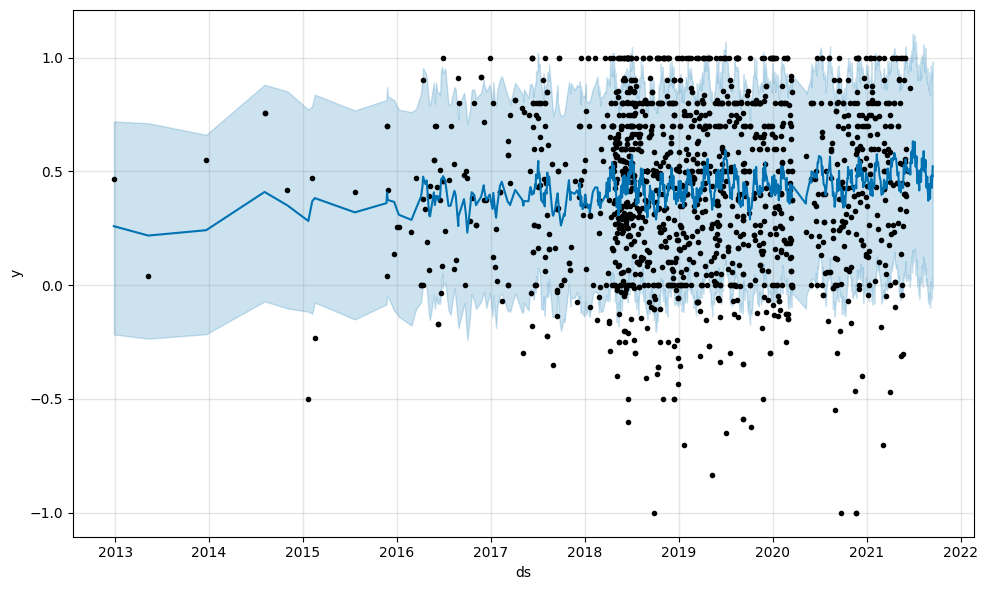

In [33]:
name = "Red Robin Gourmet Burgers and Brews"

df= filtrado[filtrado["business_name"] == name]

# Renombra las columnas a "ds" y "y"
df = df.rename(columns={'time': 'ds', 'sentimiento': 'y'})

df = df.copy()
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Crea un modelo Prophet
model = Prophet()

# Ajusta el modelo a tus datos
model.fit(df)

# Genera un DataFrame con fechas futuras para hacer predicciones
future = model.make_future_dataframe(periods=90)  # Aquí puedes ajustar el período que desees

forecast = model.predict(future)

fig = model.plot(forecast)
plt.show()

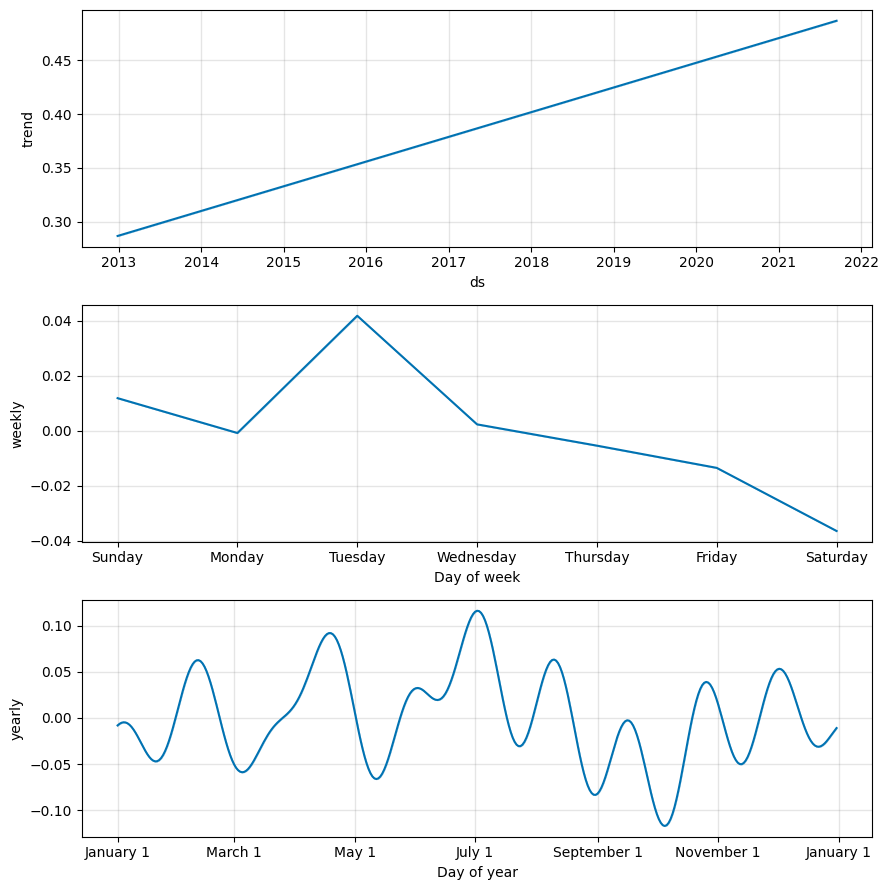

In [34]:
model.plot_components(forecast)
plt.show()

### Tendencia - Pendiente
Analizamos la pendiente de la tendencia. Dado que es el dato que aqui nos interesa, extraemos cuál es la pendiente de la función que expresa la tendencia de los datos (polaridad). 

In [35]:
forecast['days_from_start'] = (forecast['ds'] - forecast['ds'].min()).dt.days

# Realiza la regresión lineal
pendiente, _ = np.polyfit(forecast['days_from_start'], forecast['trend'], 1)

pendiente

6.288848322057896e-05

Encontramos un restaurant donde sus comentarios y opiniones no fueron favorables en el tiempo

20:41:55 - cmdstanpy - INFO - Chain [1] start processing
20:41:55 - cmdstanpy - INFO - Chain [1] done processing


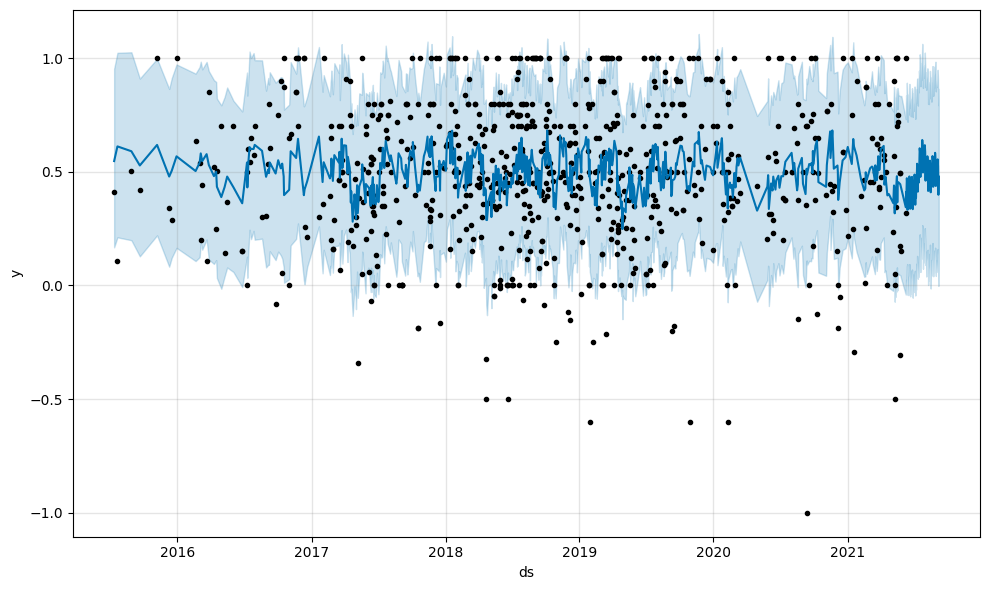

In [36]:
name = "The Habit Burger Grill"

df= filtrado[filtrado["business_name"] == name]

# Renombra las columnas a "ds" y "y"
df = df.rename(columns={'time': 'ds', 'sentimiento': 'y'})

df = df.copy()
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Crea un modelo Prophet
model = Prophet()

# Ajusta el modelo a tus datos
model.fit(df)

# Genera un DataFrame con fechas futuras para hacer predicciones
future = model.make_future_dataframe(periods=90)  # Aquí puedes ajustar el período que desees

forecast = model.predict(future)

fig = model.plot(forecast)
plt.show()

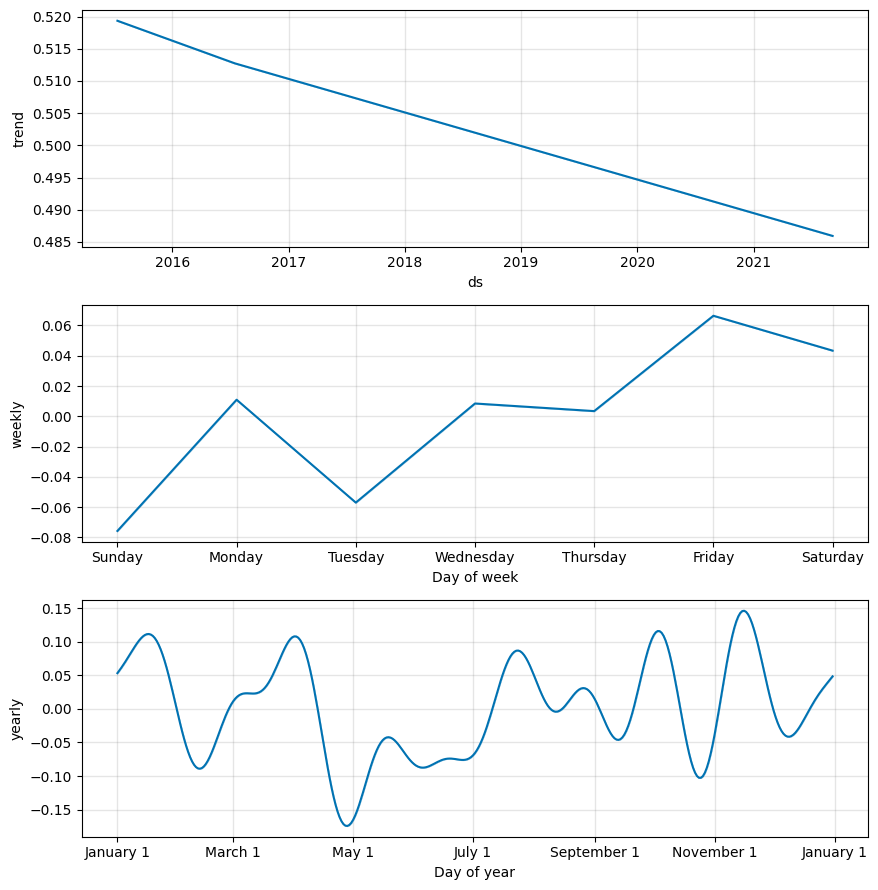

In [37]:
model.plot_components(forecast)
plt.show()

In [39]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-13,0.519344,0.162904,0.924176,0.519344,0.519344,0.027702,0.027702,0.027702,0.010969,0.010969,0.010969,0.016733,0.016733,0.016733,0.0,0.0,0.0,0.547046
1,2015-07-22,0.519182,0.238075,1.017669,0.519182,0.519182,0.092415,0.092415,0.092415,0.008471,0.008471,0.008471,0.083945,0.083945,0.083945,0.0,0.0,0.0,0.611598
2,2015-08-29,0.518500,0.201707,0.973204,0.518500,0.518500,0.071793,0.071793,0.071793,0.043394,0.043394,0.043394,0.028399,0.028399,0.028399,0.0,0.0,0.0,0.590293
3,2015-09-21,0.518088,0.130109,0.935337,0.518088,0.518088,0.009652,0.009652,0.009652,0.010969,0.010969,0.010969,-0.001317,-0.001317,-0.001317,0.0,0.0,0.0,0.527740
4,2015-11-07,0.517244,0.217410,0.975900,0.517244,0.517244,0.100849,0.100849,0.100849,0.043394,0.043394,0.043394,0.057455,0.057455,0.057455,0.0,0.0,0.0,0.618093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,2022-06-04,0.482080,0.033489,0.846119,0.481973,0.482178,-0.043418,-0.043418,-0.043418,0.043394,0.043394,0.043394,-0.086811,-0.086811,-0.086811,0.0,0.0,0.0,0.438662
912,2022-06-05,0.482065,-0.066575,0.712151,0.481957,0.482165,-0.163135,-0.163135,-0.163135,-0.075720,-0.075720,-0.075720,-0.087414,-0.087414,-0.087414,0.0,0.0,0.0,0.318931
913,2022-06-06,0.482051,0.018361,0.779819,0.481943,0.482151,-0.076533,-0.076533,-0.076533,0.010969,0.010969,0.010969,-0.087502,-0.087502,-0.087502,0.0,0.0,0.0,0.405518
914,2022-06-07,0.482037,-0.048955,0.722389,0.481928,0.482137,-0.144112,-0.144112,-0.144112,-0.056987,-0.056987,-0.056987,-0.087125,-0.087125,-0.087125,0.0,0.0,0.0,0.337924


In [40]:
forecast['days_from_start'] = (forecast['ds'] - forecast['ds'].min()).dt.days

# Realiza la regresión lineal
pendiente, _ = np.polyfit(forecast['days_from_start'], forecast['trend'], 1)

pendiente

-1.4310615183167532e-05

### Función de Pendiente
Programamos la función para extraer la pendiente

In [41]:
def calcular_pendiente(name, filtrado):
    # Filtrar el DataFrame original por nombre
    df = filtrado[filtrado["business_name"] == name]
    
    # Renombrar las columnas
    df = df.rename(columns={'time': 'ds', 'sentimiento': 'y'})
    
    df = df.copy()
    
    df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')
    
    model = Prophet()
    model.fit(df)
    
    future = model.make_future_dataframe(periods=90)
    forecast = model.predict(future)
    
    # Calcular los días desde el inicio
    forecast['days_from_start'] = (forecast['ds'] - forecast['ds'].min()).dt.days
    
    # Realizar la regresión lineal
    pendiente, _ = np.polyfit(forecast['days_from_start'], forecast['trend'], 1)
    
    return pendiente

# Supongamos que tienes una lista de restaurantes únicos en DFUnico
resultados = []

for restaurante in dfUnico:
    pendiente = calcular_pendiente(restaurante, filtrado)
    resultados.append({'Restaurante': restaurante, 'Pendiente': pendiente})

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados)

20:41:57 - cmdstanpy - INFO - Chain [1] start processing
20:41:57 - cmdstanpy - INFO - Chain [1] done processing
20:41:58 - cmdstanpy - INFO - Chain [1] start processing
20:41:58 - cmdstanpy - INFO - Chain [1] done processing
20:41:58 - cmdstanpy - INFO - Chain [1] start processing
20:41:58 - cmdstanpy - INFO - Chain [1] done processing
20:41:58 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:42:00 - cmdstanpy - INFO - Chain [1] done processing
20:42:00 - cmdstanpy - INFO - Chain [1] start processing
20:42:01 - cmdstanpy - INFO - Chain [1] done processing
20:42:01 - cmdstanpy - INFO - Chain [1] start processing
20:42:01 - cmdstanpy - INFO - Chain [1] done processing
20:42:02 - cmdstanpy - INFO - Chain [1] start processing
20:42:02 - cmdstanpy - INFO - Chain [1] done processing
20:42:02 - cmdstanpy - INFO - Chain [1] start processing
20:42:02 - cmdstanpy - INFO - Chain [1]

In [42]:
resultados_df.sort_values(by="Pendiente", ascending=False)

,Restaurante,Pendiente
49,Tony Roma's,0.000206
90,Carmelita's Mexican Restaurant,0.000148
120,Beach Road Fish House & Chicken Dinners,0.000135
148,Ole Times Country Buffet,0.000102
144,Ida Claire,0.000094
...,...,...
126,Fuddruckers,-0.000086
123,Voyager's Smokehouse,-0.000090
85,Latin Creations,-0.000102
56,Texas de Brazil,-0.000117


Conociendo la pendiente de cada uno de los restaurants, procedemos a extraer los que poseen pendiente positiva

In [43]:
# Contar restaurantes con pendiente positiva
restaurantes_con_pendiente_positiva = resultados_df[resultados_df['Pendiente'] > 0].shape[0]

# Contar restaurantes con pendiente negativa
restaurantes_con_pendiente_negativa = resultados_df[resultados_df['Pendiente'] < 0].shape[0]

print("Restaurantes con pendiente positiva:", restaurantes_con_pendiente_positiva)
print("Restaurantes con pendiente negativa:", restaurantes_con_pendiente_negativa)
print("Total de Restaurantes", len(resultados_df))

Restaurantes con pendiente positiva: 151
Restaurantes con pendiente negativa: 100
Total de Restaurantes 251


In [44]:
print(resultados_df[resultados_df["Restaurante"]=="1-800-Lucky"])

     Restaurante  Pendiente
217  1-800-Lucky   0.000021


In [45]:
lista_positivos = resultados_df[resultados_df['Pendiente'] > 0]
a = lista_positivos["Restaurante"].values

In [46]:
filtrado_positivos = dfMain[dfMain["business_name"].isin(a)]

In [47]:
len(filtrado_positivos)

243089

Realizamos unas pruebas adicionales

20:43:31 - cmdstanpy - INFO - Chain [1] start processing
20:43:31 - cmdstanpy - INFO - Chain [1] done processing


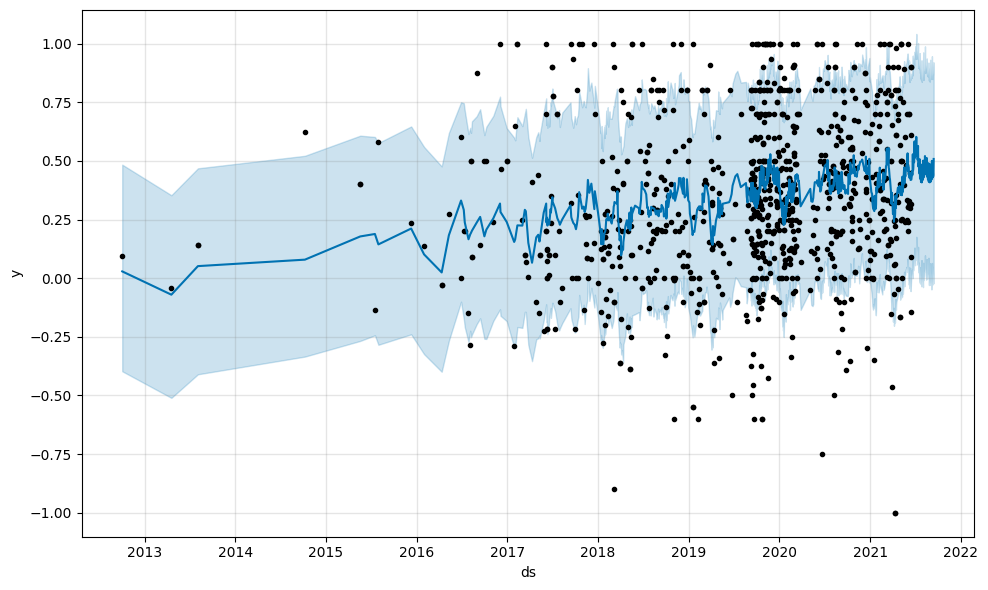

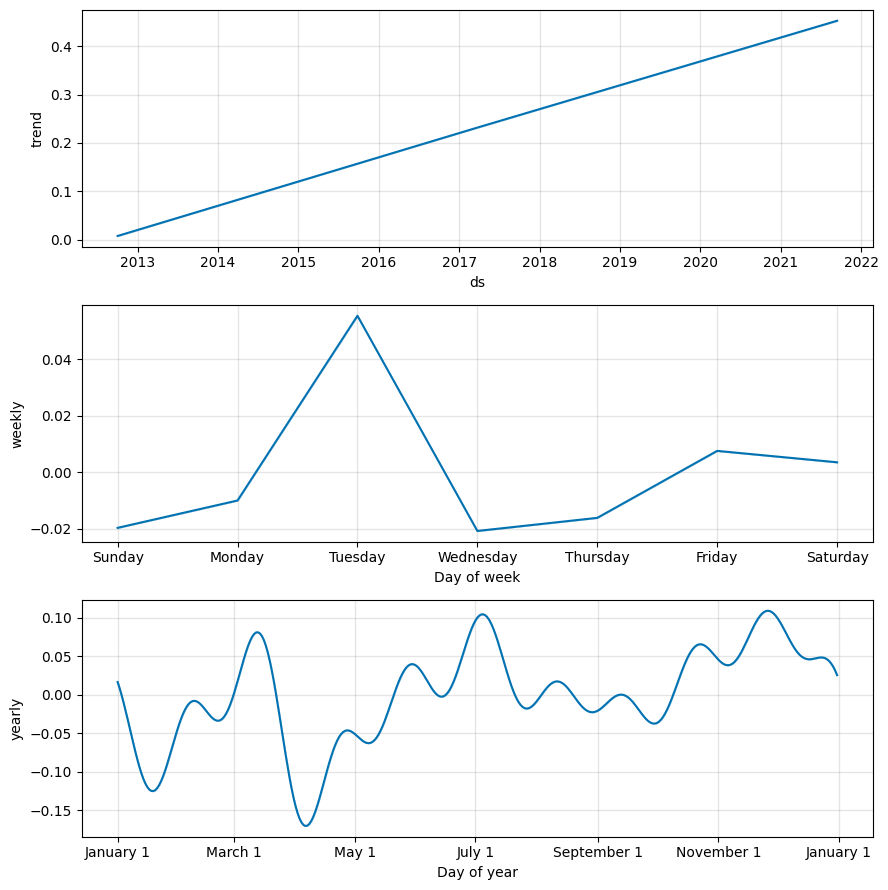

0.00013547182670798456

In [48]:
name = "Beach Road Fish House & Chicken Dinners"

df= filtrado[filtrado["business_name"] == name]

# Renombra las columnas a "ds" y "y"
df = df.rename(columns={'time': 'ds', 'sentimiento': 'y'})

df = df.copy()
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Crea un modelo Prophet
model = Prophet()

# Ajusta el modelo a tus datos
model.fit(df)

# Genera un DataFrame con fechas futuras para hacer predicciones
future = model.make_future_dataframe(periods=90)  # Aquí puedes ajustar el período que desees

forecast = model.predict(future)

fig = model.plot(forecast)
plt.show()

model.plot_components(forecast)
plt.show()

forecast['days_from_start'] = (forecast['ds'] - forecast['ds'].min()).dt.days

# Realiza la regresión lineal
pendiente, _ = np.polyfit(forecast['days_from_start'], forecast['trend'], 1)

pendiente

### Gráficos Adicionales
Extraemos y conocemos a través de gráficos adicionales la hipótesis planteada

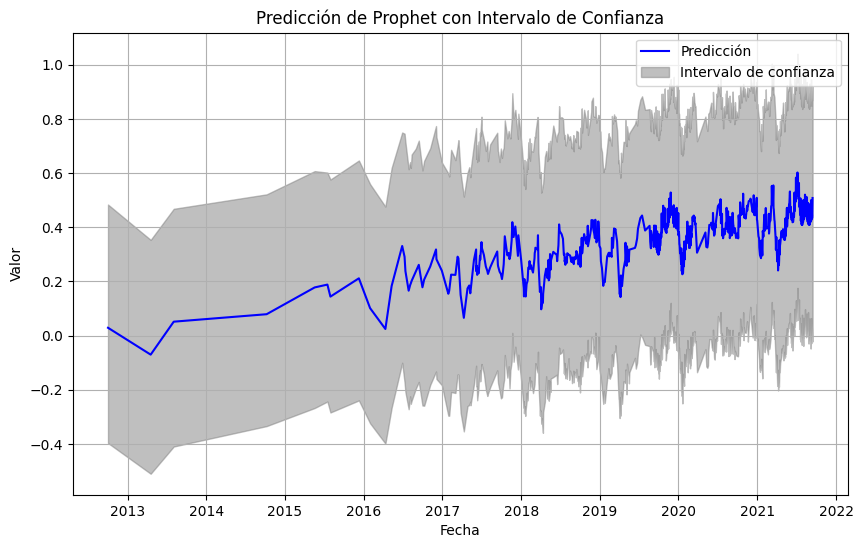

In [49]:
import matplotlib.pyplot as plt

# Extraer los datos de predicción y los intervalos de confianza
ds = forecast['ds']
yhat = forecast['yhat']
yhat_lower = forecast['yhat_lower']
yhat_upper = forecast['yhat_upper']

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(ds, yhat, label='Predicción', color='blue')
plt.fill_between(ds, yhat_lower, yhat_upper, color='gray', alpha=0.5, label='Intervalo de confianza')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicción de Prophet con Intervalo de Confianza')
plt.legend()
plt.grid(True)
plt.show()

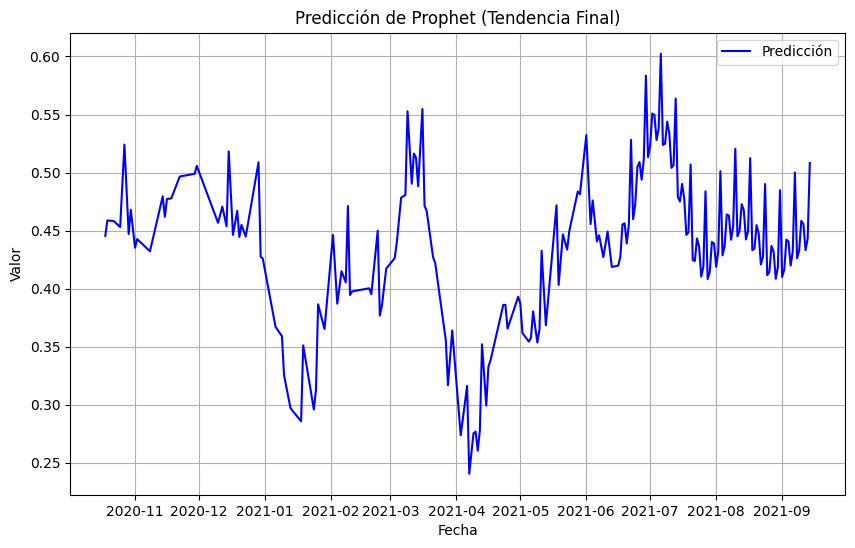

In [50]:
# Extraer los datos de predicción y los intervalos de confianza para los últimos registros
last_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(200)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(last_forecast['ds'], last_forecast['yhat'], label='Predicción', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicción de Prophet (Tendencia Final)')
plt.legend()
plt.grid(True)
plt.show()

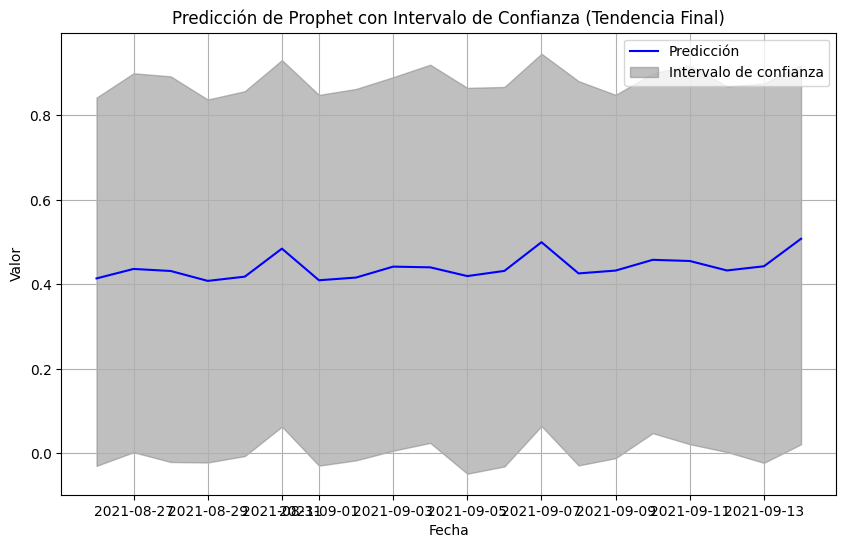

In [51]:
import matplotlib.pyplot as plt

# Extraer los datos de predicción y los intervalos de confianza para los últimos registros
last_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(last_forecast['ds'], last_forecast['yhat'], label='Predicción', color='blue')
plt.fill_between(last_forecast['ds'], last_forecast['yhat_lower'], last_forecast['yhat_upper'], color='gray', alpha=0.5, label='Intervalo de confianza')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicción de Prophet con Intervalo de Confianza (Tendencia Final)')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
dfzonafresca = dfMain[dfMain["business_name"] == "Zona Fresca"]

In [53]:
# Función para obtener la polaridad del texto
def obtener_sentimiento(texto):
    analysis = TextBlob(texto)
    return analysis.sentiment.polarity


dfzonafresca['sentimiento'] = dfzonafresca['text'].apply(obtener_sentimiento)

/var/folders/v1/fh4jbhjn7zz3zz1zl34vhly00000gn/T/ipykernel_20511/2484580146.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfzonafresca['sentimiento'] = dfzonafresca['text'].apply(obtener_sentimiento)


<Axes: >

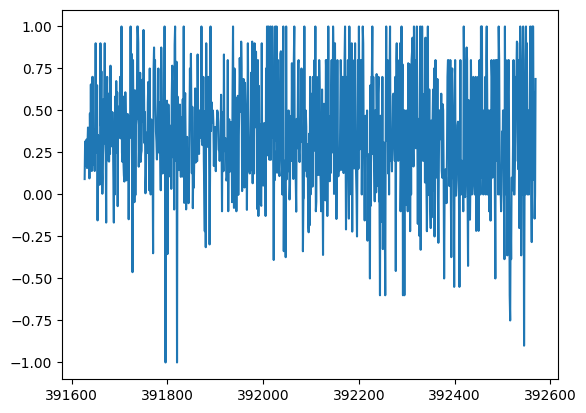

In [54]:
df["y"].plot()

In [55]:
df["y"]

391627    0.091667
391628    0.315476
391629    0.171667
391630    0.250198
391631    0.327083
            ...   
392565    0.088889
392566    0.608333
392567   -0.143590
392568   -0.004773
392569    0.687500
Name: y, Length: 943, dtype: float64

In [56]:
dfzonafresca.describe()

,latitude,longitude,avg_rating,num_of_reviews,time,rating,year,sentimiento
count,5.900000e+01,59.000000,5.900000e+01,59.0,59,59.000000,59.000000,59.000000
mean,2.610156e+01,-80.130464,4.600000e+00,148.0,2020-04-15 17:53:53.898305024,4.728814,2019.711864,0.466228
min,2.610156e+01,-80.130464,4.600000e+00,148.0,2019-07-30 00:00:00,1.000000,2019.000000,-0.600000
25%,2.610156e+01,-80.130464,4.600000e+00,148.0,2019-11-09 00:00:00,5.000000,2019.000000,0.316667
50%,2.610156e+01,-80.130464,4.600000e+00,148.0,2020-01-23 00:00:00,5.000000,2020.000000,0.495833
75%,2.610156e+01,-80.130464,4.600000e+00,148.0,2020-09-03 00:00:00,5.000000,2020.000000,0.633333
max,2.610156e+01,-80.130464,4.600000e+00,148.0,2021-06-11 00:00:00,5.000000,2021.000000,1.000000
std,3.583210e-15,0.000000,1.791605e-15,0.0,NaN,0.690590,0.696069,0.280702


### Varios - Extracción de Archivos
Funciones extras para extraer las bases de datos aqui analizadas y filtradas

In [60]:
filtrado.to_csv("predicciontendencia.csv")
filtrado_positivos2 = filtrado_positivos.drop_duplicates(subset="business_name", keep="first")
filtrado_positivos2.to_csv("Streamlit/predicciontendencia.csv")
len(filtrado_positivos2)